# Gated Multimodal Units (GMU)

---

**Title**: GATED MULTIMODAL UNITS FOR INFORMATION FUSION

 **Authors**: Arevalo, John; Montes-y-Gomez, Manuel; Solorio, Thamar and Gonzalez, Fabio A.

 [Paper](https://arxiv.org/pdf/1702.01992.pdf)

**This work**: A. Pastor López-Monroy and Diego A. Morgal

## Libraries

In [1]:
%%capture
!pip install transformers
!pip install bertviz
!pip install jsonlines

In [2]:
# Python tools
from sklearn.metrics import average_precision_score
from collections import Counter
from argparse import Namespace
from tqdm.notebook import tqdm
import numpy as np
import jsonlines
import functools
import pickle
import shutil
import json
import math
import os
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# HuggingFace
from transformers import BertTokenizer, BertModel

## Vocabulary Class

In [3]:
class Vocab(object):
    def __init__(self, emptyInit=False):
        if emptyInit:
            self.stoi, self.itos, self.vocab_sz = {}, [], 0
        else:
            self.stoi = {
                w: i
                for i, w in enumerate(["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
            }
            self.itos = [w for w in self.stoi]
            self.vocab_sz = len(self.itos)

    def add(self, words):
        cnt = len(self.itos)
        for w in words:
            if w in self.stoi:
                continue
            self.stoi[w] = cnt
            self.itos.append(w)
            cnt += 1
        self.vocab_sz = len(self.itos)

## Dataset

In [4]:
class JsonlDataset(Dataset):
    def __init__(self, data_path, tokenizer, vocab, args, data_dict=None):
        if data_dict is not None:
            self.data = data_dict
        else:
            self.data = [json.loads(l) for l in open(data_path)]
        self.data_dir = os.path.dirname(data_path)
        self.tokenizer = tokenizer
        self.args = args
        self.vocab = vocab
        self.n_classes = len(args.labels)
        self.text_start_token = ["[CLS]"]

        self.max_seq_len = args.max_seq_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = segment = None
        
        # Process plot text
        sentence = (
            self.text_start_token
            + self.tokenizer(self.data[index]["synopsis"])[:(self.args.max_seq_len - 1)]
        )
        
        segment = torch.zeros(len(sentence))
        sentence = torch.LongTensor(
            [
                self.vocab.stoi[w] if w in self.vocab.stoi else self.vocab.stoi["[UNK]"]
                for w in sentence
            ]
        )
        
        # Process labels
        label = torch.zeros(self.n_classes)
        label[
            [self.args.labels.index(tgt) for tgt in self.data[index]["label"]]
        ] = 1

        # Load visual features
        image = None            
        if self.args.model in ["gmu_clf_original", "gmu_clf_hierarchical", "gmu_clf_softmax", "gmu_clf_bimodal"]:
            file = open(os.path.join(self.data_dir, 'video_frames', f'{str(self.data[index]["id"])}.pt'), 'rb')
            image = torch.load(file).squeeze(0)

        # Load audio spectrograms
        audio = None
        if self.args.model in ["gmu_clf_original", "gmu_clf_hierarchical", "gmu_clf_softmax"]:
            file = open(os.path.join(self.data_dir, 'spectrograms', f'{str(self.data[index]["id"])}.pt'), 'rb')
            audio = torch.load(file).squeeze(0)

        return sentence, segment, image, label, audio

## Collate function to process batch

In [5]:
def collate_fn(batch, args):
    lens = [len(row[0]) for row in batch]
    bsz, max_seq_len = len(batch), max(lens)

    mask_tensor = torch.zeros(bsz, max_seq_len).long()
    text_tensor = torch.zeros(bsz, max_seq_len).long()
    segment_tensor = torch.zeros(bsz, max_seq_len).long()

    video_tensor = None
    if batch[0][2] is not None:
        video_tensor = torch.stack([row[2] for row in batch])

    audio_tensor = None
    if batch[0][4] is not None:
        audio_lens = [row[4].shape[1] for row in batch]
        audio_min_len = min(audio_lens)
        audio_tensor = torch.stack([row[4][..., :audio_min_len] for row in batch])

    tgt_tensor = torch.stack([row[3] for row in batch])

    for i_batch, (input_row, length) in enumerate(zip(batch, lens)):
        tokens, segment = input_row[:2]
        text_tensor[i_batch, :length] = tokens
        segment_tensor[i_batch, :length] = segment
        mask_tensor[i_batch, :length] = 1

    return text_tensor, segment_tensor, mask_tensor, video_tensor, tgt_tensor, audio_tensor

## Load dataset partitions (train, validation, test)

Create `Namespace` objject for storing all parameters of model, training and data

In [6]:
args = Namespace()
args.data_path = os.path.join(os.getcwd(), "moviescope")

Download spectrograms, video frame features and data parition (labels and plots)

In [7]:
# Spectrograms
!gdown https://drive.google.com/uc?id=1wNr8qf2yMouuZ4FjpdQO4SvGaExUYLAz

Downloading...
From: https://drive.google.com/uc?id=1wNr8qf2yMouuZ4FjpdQO4SvGaExUYLAz
To: /content/sub_spectrograms.pt
100% 2.29G/2.29G [00:10<00:00, 209MB/s]


In [8]:
# Video frames
!gdown https://drive.google.com/uc?id=1zKvC9U1q0n-9_nSDcnTIEeecHWD9GbUA

Downloading...
From: https://drive.google.com/uc?id=1zKvC9U1q0n-9_nSDcnTIEeecHWD9GbUA
To: /content/sub_video_frames.pt
100% 1.64G/1.64G [00:07<00:00, 226MB/s]


In [9]:
# Labels and plots
!gdown https://drive.google.com/uc?id=1999p8LLBR6imXLCJyIeEU8owuR-QHbcH

Downloading...
From: https://drive.google.com/uc?id=1999p8LLBR6imXLCJyIeEU8owuR-QHbcH
To: /content/train.jsonl
100% 1.73M/1.73M [00:00<00:00, 117MB/s]


Unpack each observation in a separate file (all spectrograms and video frame features are downloaded as a single dictionary object)

In [10]:
!mkdir moviescope
!mkdir moviescope/spectrograms
!mkdir moviescope/video_frames
!mv -t moviescope train.jsonl

spectrograms = torch.load('sub_spectrograms.pt')
for id, tensor in spectrograms.items():
    torch.save(tensor, f'moviescope/spectrograms/{id}.pt')

video_frames = torch.load('sub_video_frames.pt')
for id, tensor in video_frames.items():
    torch.save(tensor, f'moviescope/video_frames/{id}.pt')

Generate train, validation and test splits

In [11]:
train_labels = [json.loads(line) for line in open('moviescope/train.jsonl')]

# Validation
with jsonlines.open(os.path.join(os.getcwd(), 'moviescope/dev.jsonl'), 'w') as writer:
    writer.write_all(train_labels[200:250])

# Test
with jsonlines.open(os.path.join(os.getcwd(), 'moviescope/test.jsonl'), 'w') as writer:
    writer.write_all(train_labels[250:350]) #400:])

# Train
with jsonlines.open(os.path.join(os.getcwd(), 'moviescope/train.jsonl'), 'w') as writer:
    writer.write_all(train_labels[:200])

Data structure:

* moviescope/
    * spectrograms/
    * video_frames/
    * train.jsonl
    * dev.jsonl
    * test.jsonl

In [12]:
del spectrograms, video_frames
!rm sub_spectrograms.pt
!rm sub_video_frames.pt

* From the train partition load all the different labels for classification task (movie genres) into variable `args.labels`
* Count frequencies for each label into variable `args.label_freqs`

# Genre Distribution

In [13]:
label_freqs = Counter()
data_labels = [json.loads(line)["label"] for line in open(os.path.join(args.data_path, "train.jsonl"))]

if type(data_labels[0]) == list:
    for label_row in data_labels:
        label_freqs.update(label_row)
else:
    label_freqs.update(data_labels)

args.labels = list(label_freqs.keys())
args.label_freqs = label_freqs

In [14]:
print(f"Movie genres (labels): {args.labels}")
print("Training labels distribution: ")
for label, count in args.label_freqs.items():
    print(f'    {label}: {count}')

Movie genres (labels): ['Mystery', 'Thriller', 'Comedy', 'Action', 'Crime', 'Drama', 'Family', 'Horror', 'Biography', 'Romance', 'Sci-Fi', 'Fantasy', 'Animation']
Training labels distribution: 
    Mystery: 16
    Thriller: 60
    Comedy: 76
    Action: 52
    Crime: 39
    Drama: 107
    Family: 14
    Horror: 22
    Biography: 9
    Romance: 49
    Sci-Fi: 20
    Fantasy: 20
    Animation: 5


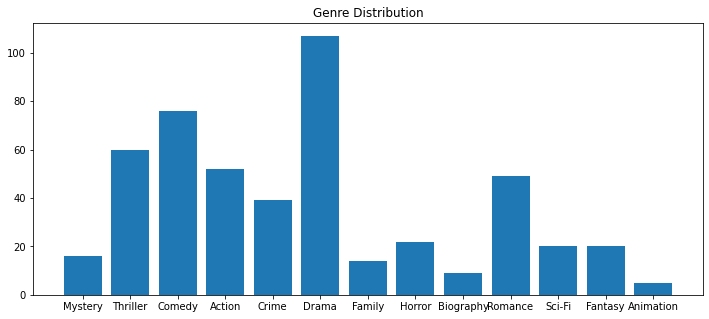

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.bar(list(args.label_freqs.keys()), list(args.label_freqs.values()))
plt.title("Genre Distribution")
plt.show()

## Create vocabulary and tokenizer

A pre-trained BERT is used for extracting text features, so `BertTokenizer` is used for preprocessing text



In [16]:
# Load BERT tokenizer for processing text with BERT model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

vocab = Vocab()
vocab.stoi = tokenizer.vocab # mapping from subword to index
vocab.itos = tokenizer.ids_to_tokens # Reverse mapping from index to subword
vocab.vocab_sz = len(vocab.itos) # Vocabulary size

args.vocab = vocab
args.vocab_sz = vocab.vocab_sz
args.n_classes = len(args.labels)
plot_tokenizer = tokenizer.tokenize # tokenize method does not add any special tokens

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Create Datasets and Dataloaders and select model

In [17]:
# Data parameters
args.max_seq_len = 512
args.batch_sz = 1
args.n_workers = 0
collate = functools.partial(collate_fn, args=args)

# Training
train = JsonlDataset(
    os.path.join(args.data_path, "train.jsonl"),
    plot_tokenizer,
    vocab,
    args,
)

train_loader = DataLoader(
    train,
    batch_size=args.batch_sz,
    shuffle=True,
    num_workers=args.n_workers,
    collate_fn=collate,
    drop_last=True,
)

args.train_data_len = len(train)


# Validation
dev = JsonlDataset(
    os.path.join(args.data_path, "dev.jsonl"),
    plot_tokenizer,
    vocab,
    args,
)

val_loader = DataLoader(
    dev,
    batch_size=args.batch_sz,
    shuffle=False,
    num_workers=args.n_workers,
    collate_fn=collate,
)

# Testing
test_set = JsonlDataset(
    os.path.join(args.data_path, "test.jsonl"),
    plot_tokenizer,
    vocab,
    args,
)

test_loader = DataLoader(
    test_set,
    batch_size=args.batch_sz,
    shuffle=False,
    num_workers=args.n_workers,
    collate_fn=collate,
)

# Models

## Text Encoder (BERT base pretrained)

In [18]:
class BertEncoder(nn.Module):
    def __init__(self, args):
        super(BertEncoder, self).__init__()
        self.args = args
        self.bert = BertModel.from_pretrained(args.bert_model)

    def forward(self, txt, mask, segment):
        encoded_layers, out = self.bert(
            input_ids=txt,
            token_type_ids=segment,
            attention_mask=mask,
            return_dict=False,
        )
        return encoded_layers, out

## Audio Encoder (CNN)

In [19]:
class AudioEncoder(nn.Module):
    def __init__(self, args):
        super(AudioEncoder, self).__init__()
        self.args = args
        
        conv_layers = []

        conv_layers.append(nn.Conv1d(96, 96, 128, stride=2))
        conv_layers.append(nn.Conv1d(96, 96, 128, stride=2))
        conv_layers.append(nn.AdaptiveAvgPool1d(200))
        self.conv_layers = nn.ModuleList(conv_layers)

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        return x

## Video (we already have VGG preprocessed features)

In [ ]:
# Nothing to do

## Transformer

In [20]:
class TransformerEncoderLayer(nn.Module):
    """Encoder layer block.
    In the original paper each operation (multi-head attention or FFN) is
    postprocessed with: `dropout -> add residual -> layernorm`. In the
    tensor2tensor code they suggest that learning is more robust when
    preprocessing each layer with layernorm and postprocessing with:
    `dropout -> add residual`. We default to the approach in the paper, but the
    tensor2tensor approach can be enabled by setting
    *args.encoder_normalize_before* to ``True``.
    Args:
        embed_dim: Embedding dimension
    """

    def __init__(self, embed_dim, num_heads=4, attn_dropout=0.1, relu_dropout=0.1, res_dropout=0.1,
                 attn_mask=False):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        
        self.self_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dim,
            num_heads=self.num_heads,
            dropout=attn_dropout
        )
        self.attn_mask = attn_mask

        self.relu_dropout = relu_dropout
        self.res_dropout = res_dropout
        self.normalize_before = True

        self.fc1 = nn.Linear(self.embed_dim, 4*self.embed_dim)   # The "Add & Norm" part in the paper
        self.fc2 = nn.Linear(4*self.embed_dim, self.embed_dim)
        self.layer_norms = nn.ModuleList([nn.LayerNorm(self.embed_dim) for _ in range(2)])

    def forward(self, x, x_k=None, x_v=None):
        """
        Args:
            x (Tensor): input to the layer of shape `(seq_len, batch, embed_dim)`
            encoder_padding_mask (ByteTensor): binary ByteTensor of shape
                `(batch, src_len)` where padding elements are indicated by ``1``.
            x_k (Tensor): same as x
            x_v (Tensor): same as x
        Returns:
            encoded output of shape `(batch, src_len, embed_dim)`
        """
        residual = x
        x = self.maybe_layer_norm(0, x, before=True)
        mask = buffered_future_mask(x, x_k) if self.attn_mask else None
        if x_k is None and x_v is None:
            x, _ = self.self_attn(query=x, key=x, value=x, attn_mask=mask)
        else:
            x_k = self.maybe_layer_norm(0, x_k, before=True)
            x_v = self.maybe_layer_norm(0, x_v, before=True) 
            x, _ = self.self_attn(query=x, key=x_k, value=x_v, attn_mask=mask)
        x = F.dropout(x, p=self.res_dropout, training=self.training)
        x = residual + x
        x = self.maybe_layer_norm(0, x, after=True)

        residual = x
        x = self.maybe_layer_norm(1, x, before=True)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.relu_dropout, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, p=self.res_dropout, training=self.training)
        x = residual + x
        x = self.maybe_layer_norm(1, x, after=True)
        return x

    def maybe_layer_norm(self, i, x, before=False, after=False):
        assert before ^ after
        if after ^ self.normalize_before:
            return self.layer_norms[i](x)
        else:
            return x

def fill_with_neg_inf(t):
    """FP16-compatible function that fills a tensor with -inf."""
    return t.float().fill_(float('-inf')).type_as(t)


def buffered_future_mask(tensor, tensor2=None):
    dim1 = dim2 = tensor.size(0)
    if tensor2 is not None:
        dim2 = tensor2.size(0)
    future_mask = torch.triu(fill_with_neg_inf(torch.ones(dim1, dim2)), 1+abs(dim2-dim1))
    if tensor.is_cuda:
        future_mask = future_mask.cuda()
    return future_mask[:dim1, :dim2]

### Positional embedding

In [21]:
# Code adapted from the fairseq repo.

def make_positions(tensor, padding_idx, left_pad):
    """Replace non-padding symbols with their position numbers.
    Position numbers begin at padding_idx+1.
    Padding symbols are ignored, but it is necessary to specify whether padding
    is added on the left side (left_pad=True) or right side (left_pad=False).
    """
    max_pos = padding_idx + 1 + tensor.size(1)
    device = tensor.get_device()
    buf_name = f'range_buf_{device}'
    if not hasattr(make_positions, buf_name):
        setattr(make_positions, buf_name, tensor.new())
    setattr(make_positions, buf_name, getattr(make_positions, buf_name).type_as(tensor))
    if getattr(make_positions, buf_name).numel() < max_pos:
        torch.arange(padding_idx + 1, max_pos, out=getattr(make_positions, buf_name))
    mask = tensor.ne(padding_idx)
    positions = getattr(make_positions, buf_name)[:tensor.size(1)].expand_as(tensor)
    if left_pad:
        positions = positions - mask.size(1) + mask.long().sum(dim=1).unsqueeze(1)
    new_tensor = tensor.clone()
    return new_tensor.masked_scatter_(mask, positions[mask]).long()


class SinusoidalPositionalEmbedding(nn.Module):
    """This module produces sinusoidal positional embeddings of any length.
    Padding symbols are ignored, but it is necessary to specify whether padding
    is added on the left side (left_pad=True) or right side (left_pad=False).
    """

    def __init__(self, embedding_dim, padding_idx=0, left_pad=0, init_size=128):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        self.left_pad = left_pad
        self.weights = dict()   # device --> actual weight; due to nn.DataParallel :-(
        self.register_buffer('_float_tensor', torch.FloatTensor(1))

    @staticmethod
    def get_embedding(num_embeddings, embedding_dim, padding_idx=None):
        """Build sinusoidal embeddings.
        This matches the implementation in tensor2tensor, but differs slightly
        from the description in Section 3.5 of "Attention Is All You Need".
        """
        half_dim = embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float) * -emb)
        emb = torch.arange(num_embeddings, dtype=torch.float).unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1).view(num_embeddings, -1)
        if embedding_dim % 2 == 1:
            # zero pad
            emb = torch.cat([emb, torch.zeros(num_embeddings, 1)], dim=1)
        if padding_idx is not None:
            emb[padding_idx, :] = 0
        return emb

    def forward(self, input):
        """Input is expected to be of size [bsz x seqlen]."""
        bsz, seq_len = input.size()
        max_pos = self.padding_idx + 1 + seq_len
        device = input.get_device()
        if device not in self.weights or max_pos > self.weights[device].size(0):
            # recompute/expand embeddings if needed
            self.weights[device] = SinusoidalPositionalEmbedding.get_embedding(
                max_pos,
                self.embedding_dim,
                self.padding_idx,
            )
        self.weights[device] = self.weights[device].type_as(self._float_tensor)
        positions = make_positions(input, self.padding_idx, self.left_pad)
        return self.weights[device].index_select(0, positions.view(-1)).view(bsz, seq_len, -1).detach()

    def max_positions(self):
        """Maximum number of supported positions."""
        return int(1e5)  # an arbitrary large number

### Transformer encoder

In [22]:
class TransformerEncoder(nn.Module):
    """
    Transformer encoder consisting of *args.encoder_layers* layers. Each layer
    is a :class:`TransformerEncoderLayer`.
    Args:
        embed_tokens (torch.nn.Embedding): input embedding
        num_heads (int): number of heads
        layers (int): number of layers
        attn_dropout (float): dropout applied on the attention weights
        relu_dropout (float): dropout applied on the first layer of the residual block
        res_dropout (float): dropout applied on the residual block
        attn_mask (bool): whether to apply mask on the attention weights
    """

    def __init__(self, embed_dim, num_heads, layers, attn_dropout=0.0, relu_dropout=0.0, res_dropout=0.0,
                 embed_dropout=0.0, attn_mask=False):
        super().__init__()
        self.dropout = embed_dropout
        self.attn_dropout = attn_dropout
        self.embed_dim = embed_dim
        self.embed_scale = math.sqrt(embed_dim)
        self.embed_positions = SinusoidalPositionalEmbedding(embed_dim)
        
        self.attn_mask = attn_mask

        self.layers = nn.ModuleList([])
        for layer in range(layers):
            new_layer = TransformerEncoderLayer(embed_dim,
                                                num_heads=num_heads,
                                                attn_dropout=attn_dropout,
                                                relu_dropout=relu_dropout,
                                                res_dropout=res_dropout,
                                                attn_mask=attn_mask)
            self.layers.append(new_layer)

        self.normalize = True
        if self.normalize:
            self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x_in, x_in_k = None, x_in_v = None):
        """
        Args:
            x_in (FloatTensor): embedded input of shape `(src_len, batch, embed_dim)`
            x_in_k (FloatTensor): embedded input of shape `(src_len, batch, embed_dim)`
            x_in_v (FloatTensor): embedded input of shape `(src_len, batch, embed_dim)`
        Returns:
            dict:
                - **encoder_out** (Tensor): the last encoder layer's output of
                  shape `(src_len, batch, embed_dim)`
                - **encoder_padding_mask** (ByteTensor): the positions of
                  padding elements of shape `(batch, src_len)`
        """
        # embed tokens and positions
        x = self.embed_scale * x_in
        if self.embed_positions is not None:
            x += self.embed_positions(x_in.transpose(0, 1)[:, :, 0]).transpose(0, 1) # Add positional embedding
        x = F.dropout(x, p=self.dropout, training=self.training)

        if x_in_k is not None and x_in_v is not None:
            # embed tokens and positions    
            x_k = self.embed_scale * x_in_k
            x_v = self.embed_scale * x_in_v
            if self.embed_positions is not None:
                x_k += self.embed_positions(x_in_k.transpose(0, 1)[:, :, 0]).transpose(0, 1) # Add positional embedding
                x_v += self.embed_positions(x_in_v.transpose(0, 1)[:, :, 0]).transpose(0, 1) # Add positional embedding
            x_k = F.dropout(x_k, p=self.dropout, training=self.training)
            x_v = F.dropout(x_v, p=self.dropout, training=self.training)
        
        # encoder layers
        intermediates = [x]
        for layer in self.layers:
            if x_in_k is not None and x_in_v is not None:
                x = layer(x, x_k, x_v)
            else:
                x = layer(x)
            intermediates.append(x)

        if self.normalize:
            x = self.layer_norm(x)

        return x

# Classifiers & GMUs

## Text classifier (just using BERT for comparison)

In [23]:
class BertClf(nn.Module):
    def __init__(self, args):
        super(BertClf, self).__init__()
        self.args = args
        self.bert = BertModel.from_pretrained(args.bert_model)
        self.clf = nn.Linear(args.hidden_sz, args.n_classes)

    def forward(self, txt, mask, segment):
        _, x = self.bert(
            input_ids=txt,
            token_type_ids=segment,
            attention_mask=mask,
            return_dict=False,
        )
        return self.clf(x)

## GMU Original (Arévalo)

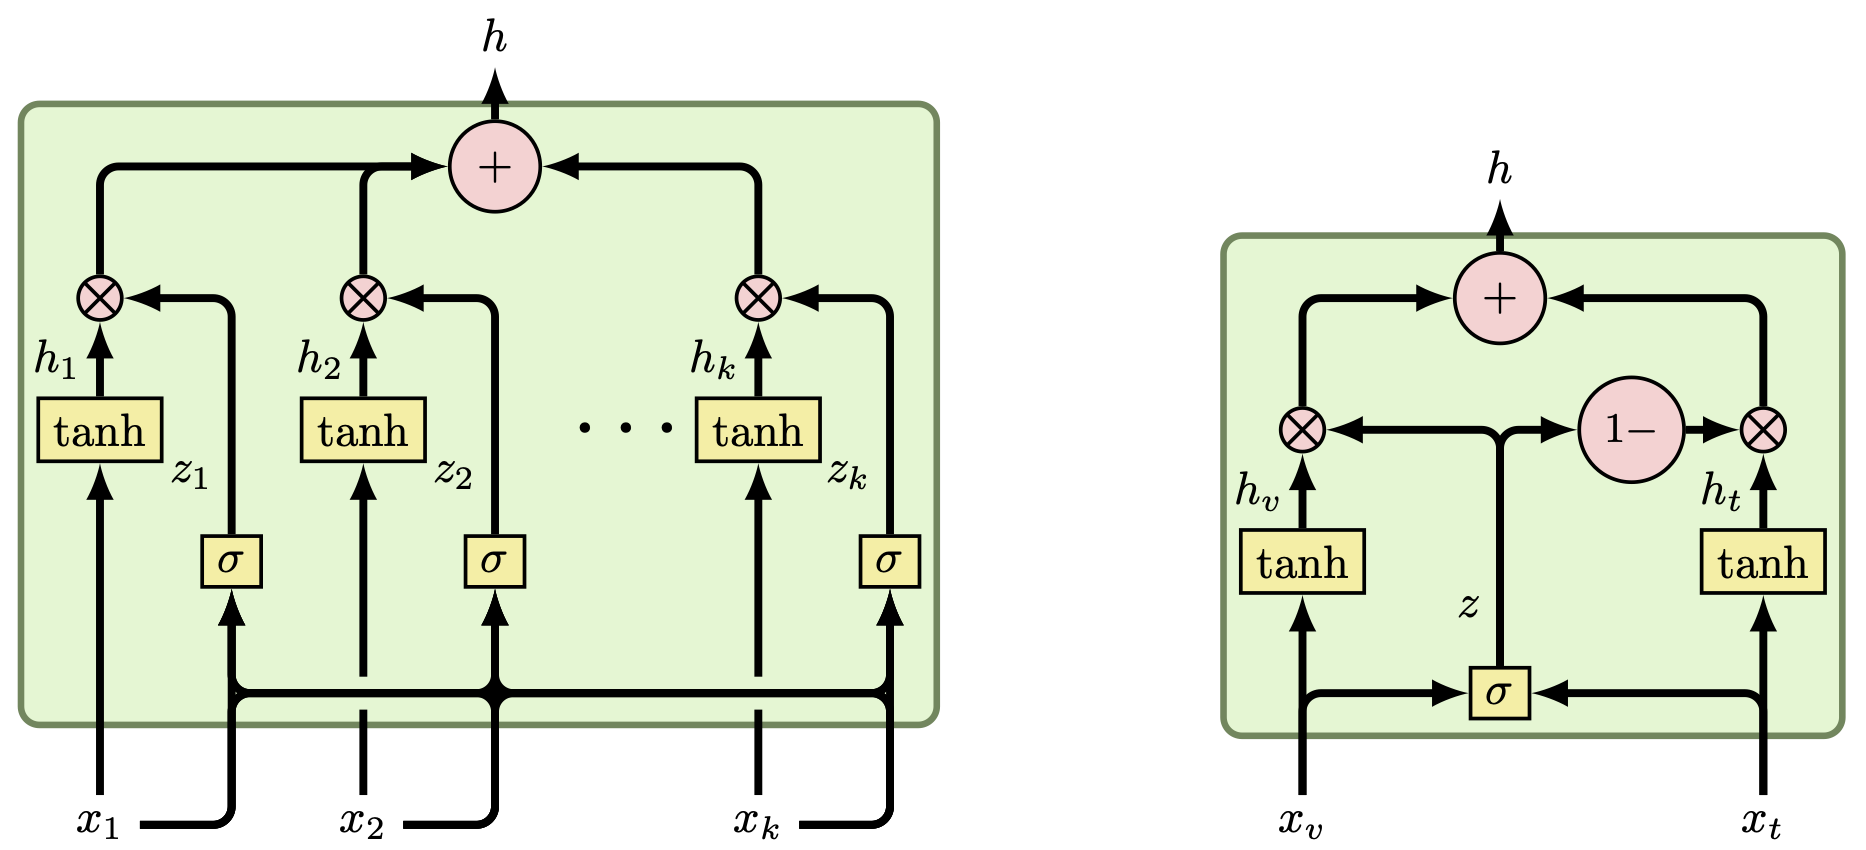

In [24]:
class GMU(nn.Module):
    """ Layer inspired by 'Gated multimodal networks, Arevalo1 et al.' (https://arxiv.org/abs/1702.01992) """
    def __init__(self, size_in1, size_in2, size_out):
        super(GMU, self).__init__()
        self.size_in1, self.size_in2, self.size_out = size_in1, size_in2, size_out
        
        self.hidden1 = nn.Linear(size_in1, size_out, bias=False)
        self.hidden2 = nn.Linear(size_in2, size_out, bias=False)
        self.x_gate = nn.Linear(size_in1+size_in2, size_out, bias=False)

    def forward(self, x1, x2):
        h1 = torch.tanh(self.hidden1(x1))
        h2 = torch.tanh(self.hidden2(x2))
        x_cat = torch.cat((x1, x2), dim=-1)
        z1 = torch.sigmoid(self.x_gate(x_cat))

        return z1*h1 + (1-z1)*h2, torch.cat((z1, 1-z1), dim=-1)

class GMU_3D(nn.Module):
    """ Layer inspired by 'Gated multimodal networks, Arevalo1 et al.' (https://arxiv.org/abs/1702.01992) """
    def __init__(self, size_in1, size_in2, size_in3, size_out):
        super(GMU_3D, self).__init__()
        self.size_in1, self.size_in2, self.size_in3, self.size_out = size_in1, size_in2, size_in3, size_out
        
        self.hidden1 = nn.Linear(size_in1, size_out, bias=False)
        self.hidden2 = nn.Linear(size_in2, size_out, bias=False)
        self.hidden3 = nn.Linear(size_in3, size_out, bias=False)
        self.x1_gate = nn.Linear(size_in1+size_in2+size_in3, size_out, bias=False)
        self.x2_gate = nn.Linear(size_in1+size_in2+size_in3, size_out, bias=False)
        self.x3_gate = nn.Linear(size_in1+size_in2+size_in3, size_out, bias=False)

    def forward(self, x1, x2, x3):
        h1 = torch.tanh(self.hidden1(x1))
        h2 = torch.tanh(self.hidden2(x2))
        h3 = torch.tanh(self.hidden3(x3))
        x_cat = torch.cat((x1, x2, x3), dim=-1)
        z1 = torch.sigmoid(self.x1_gate(x_cat))
        z2 = torch.sigmoid(self.x2_gate(x_cat))
        z3 = torch.sigmoid(self.x3_gate(x_cat))

        return z1*h1 + z2*h2 + z3*h3, torch.cat((z1, z2, z3), dim=-1)

## Hierarchical GMU

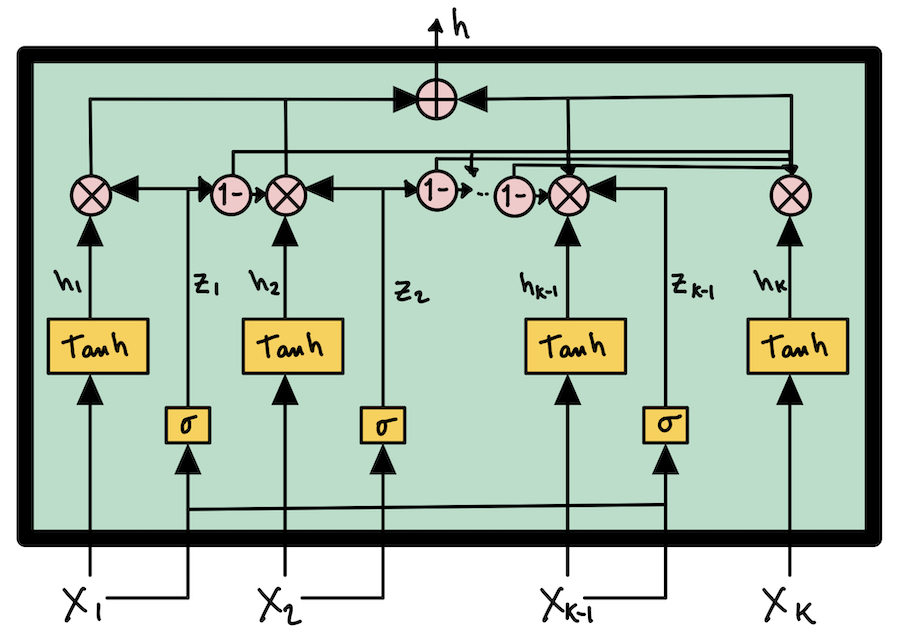

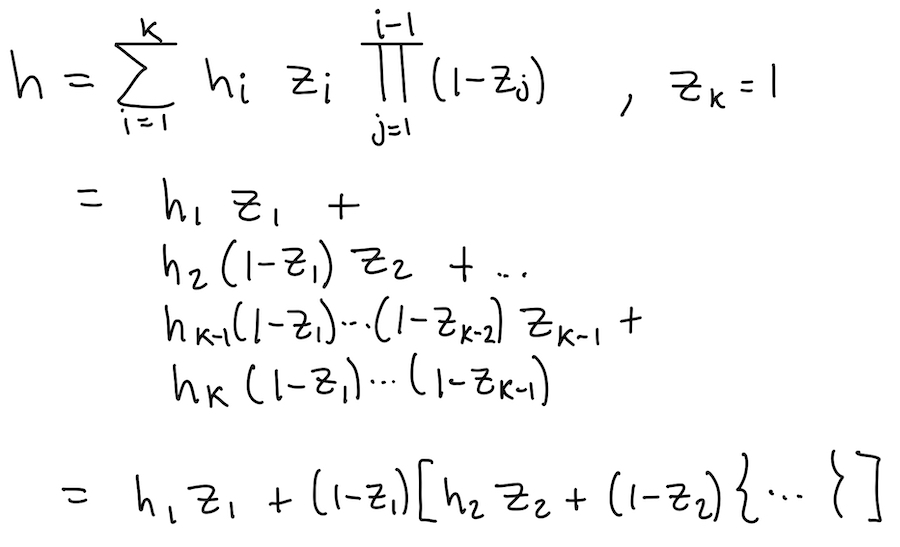


In [25]:
class GMU_3D_hierarchical(nn.Module):
    """ Layer inspired by 'Gated multimodal networks, Arevalo1 et al.' (https://arxiv.org/abs/1702.01992) """
    def __init__(self, size_in1, size_in2, size_in3, size_out):
        super(GMU_3D_hierarchical, self).__init__()
        self.size_in1, self.size_in2, self.size_in3, self.size_out = size_in1, size_in2, size_in3, size_out
        
        self.hidden1 = nn.Linear(size_in1, size_out, bias=False)
        self.hidden2 = nn.Linear(size_in2, size_out, bias=False)
        self.hidden3 = nn.Linear(size_in3, size_out, bias=False)
        self.x1_gate = nn.Linear(size_in1+size_in2+size_in3, size_out, bias=False)
        self.x2_gate = nn.Linear(size_in1+size_in2+size_in3, size_out, bias=False)

    def forward(self, x1, x2, x3):
        h1 = torch.tanh(self.hidden1(x1))
        h2 = torch.tanh(self.hidden2(x2))
        h3 = torch.tanh(self.hidden3(x3))
        x_cat = torch.cat((x1, x2, x3), dim=-1)
        z1 = torch.sigmoid(self.x1_gate(x_cat))
        z2 = torch.sigmoid(self.x2_gate(x_cat))

        return z1*h1 + (1-z1)*z2*h2 + (1-z1)*(1-z2)*h3, torch.cat((z1, (1-z1)*z2, (1-z1)*(1-z2)), dim=-1)

## GMU with Softmax

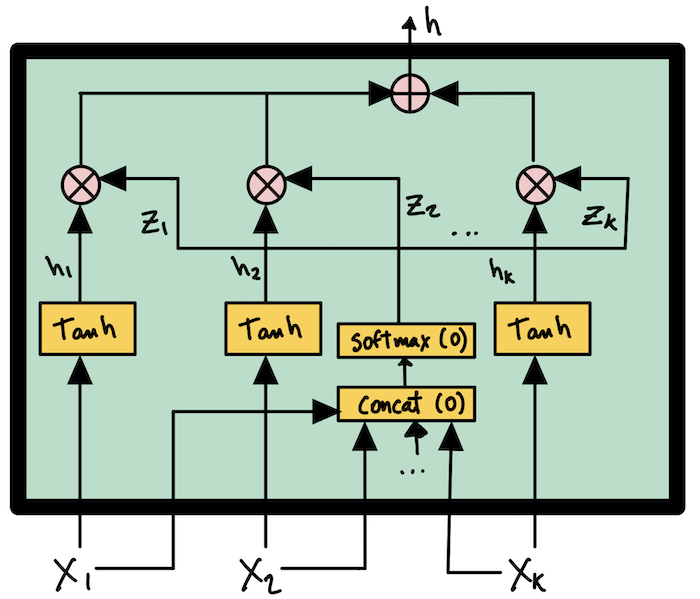

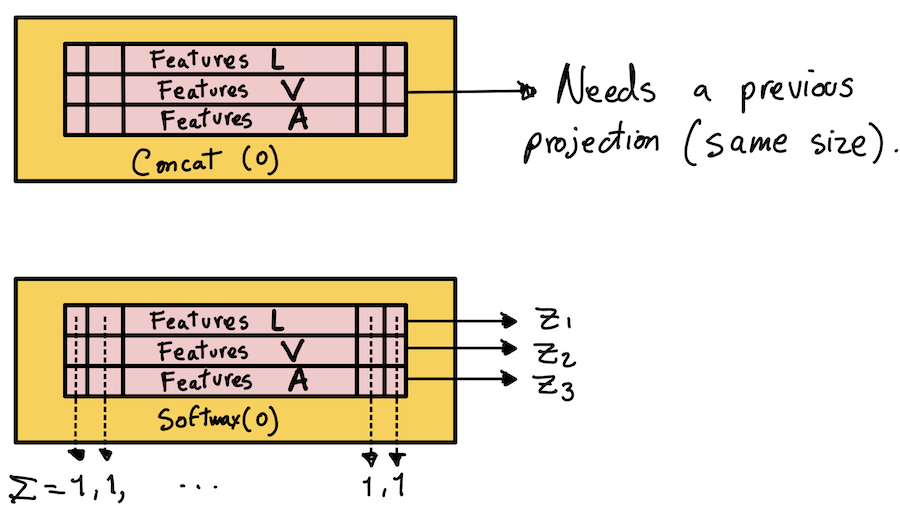

In [26]:
class GMU_3D_softmax(nn.Module):
    """ Layer inspired by 'Gated multimodal networks, Arevalo1 et al.' (https://arxiv.org/abs/1702.01992) """
    def __init__(self, size_in1, size_in2, size_in3, size_out):
        super(GMU_3D_softmax, self).__init__()
        self.size_in1, self.size_in2, self.size_in3, self.size_out = size_in1, size_in2, size_in3, size_out
        self.ind_1 = self.ind_2 = self.ind_3 = False
        
        self.hidden1 = nn.Linear(size_in1, size_out, bias=False)
        self.hidden2 = nn.Linear(size_in2, size_out, bias=False)
        self.hidden3 = nn.Linear(size_in3, size_out, bias=False)
        self.x1_gate = nn.Linear(size_out, size_out, bias=False)

        if size_in1 != size_out:
          self.ind_1 = True
          self.transform_1 = nn.Linear(size_in1, size_out, bias=False)
        if size_in2 != size_out:
          self.ind_2 = True
          self.transform_2 = nn.Linear(size_in2, size_out, bias=False)
        if size_in3 != size_out:
          self.ind_3 = True
          self.transform_3 = nn.Linear(size_in3, size_out, bias=False)

    def forward(self, x1, x2, x3):
        h1 = torch.tanh(self.hidden1(x1))
        h2 = torch.tanh(self.hidden2(x2))
        h3 = torch.tanh(self.hidden3(x3))

        x1_t = self.transform_1(x1) if self.ind_1 else x1
        x2_t = self.transform_2(x2) if self.ind_2 else x2
        x3_t = self.transform_3(x3) if self.ind_3 else x3
        
        x_cat = torch.cat((x1_t.unsqueeze(0), x1_t.unsqueeze(0), x1_t.unsqueeze(0)), dim=0)
        z = torch.softmax(self.x1_gate(x_cat), dim=0)

        return z[0]*h1 + z[1]*h2 + z[2]*h3, torch.cat((z[0], z[1], z[2]), dim=-1)
        

## Multimodal Classifier with GMU (Text + Video + Audio)

In [51]:
class GMUClf(nn.Module):
    def __init__(self, args):
        """
        Construct a Simple model for Text, Video frames and Audio spectrogram with GMU late fusion.
        """
        super(GMUClf, self).__init__()
        self.args = args
        self.orig_d_l, self.orig_d_v, self.orig_d_a = args.orig_d_l, args.orig_d_v, args.orig_d_a
        self.d_l, self.d_a, self.d_v = 768, 768, 768
        self.v_len = args.v_len
        self.l_len = args.l_len
        self.a_len = args.a_len
        self.vonly = args.vonly
        self.lonly = args.lonly
        self.aonly = args.aonly
        self.relu_dropout = args.relu_dropout
        self.res_dropout = args.res_dropout
        self.out_dropout = args.out_dropout
        self.embed_dropout = args.embed_dropout
        self.GMU = args.GMU
        
        self.enc = BertEncoder(args)
        self.audio_enc = AudioEncoder(args)

        combined_dim = 768 # For GMU
        
        output_dim = args.n_classes        # This is actually not a hyperparameter :-)

        # 1. Temporal convolutional layers
        self.proj_l = nn.Conv1d(self.orig_d_l, self.d_l, kernel_size=1, padding=0, bias=False)
        self.proj_v = nn.Conv1d(self.orig_d_v, self.d_v, kernel_size=1, padding=0, bias=False)
        self.proj_a = nn.Conv1d(self.orig_d_a, self.d_a, kernel_size=1, padding=0, bias=False)

        self.trans_a = TransformerEncoder(embed_dim=self.d_a,
                                  num_heads=args.num_heads,
                                  layers=max(args.layers, -1),
                                  attn_dropout=args.attn_dropout,
                                  relu_dropout=self.relu_dropout,
                                  res_dropout=self.res_dropout,
                                  embed_dropout=self.embed_dropout,
                                  attn_mask=args.attn_mask)
        self.trans_v = TransformerEncoder(embed_dim=self.d_v,
                                  num_heads=args.num_heads,
                                  layers=max(args.layers, -1),
                                  attn_dropout=args.attn_dropout,
                                  relu_dropout=self.relu_dropout,
                                  res_dropout=self.res_dropout,
                                  embed_dropout=self.embed_dropout,
                                  attn_mask=args.attn_mask)

        # 3. Projection layers
        self.proj1 = nn.Linear(combined_dim, combined_dim)
        self.proj2 = nn.Linear(combined_dim, combined_dim)
        self.out_layer = nn.Linear(combined_dim, output_dim)
        
        # GMU layer for fusing text and image and audio information
        if self.GMU == 'original':
          self.gmu = GMU_3D(self.d_l, self.d_v, self.d_a, self.d_l)
        elif self.GMU == 'hierarchical':
          self.gmu = GMU_3D_hierarchical(self.d_l, self.d_v, self.d_a, self.d_l)
        elif self.GMU == 'softmax':
          self.gmu = GMU_3D_softmax(self.d_l, self.d_v, self.d_a, self.d_l)
            
    def forward(self, txt, mask, segment, img, audio):
        """
        text, audio, and vision should have dimension [batch_size, seq_len, n_features]
        """
        x_l, x_l_cls = self.enc(txt, mask, segment)
        x_l = F.dropout(x_l.transpose(1, 2), p=self.embed_dropout, training=self.training)
        x_v = img.transpose(1, 2)
        x_a = self.audio_enc(audio)

        # Project the textual/visual/audio features
        proj_x_l = x_l if self.orig_d_l == self.d_l else self.proj_l(x_l)
        proj_x_a = x_a if self.orig_d_a == self.d_a else self.proj_a(x_a)
        proj_x_v = x_v if self.orig_d_v == self.d_v else self.proj_v(x_v)
        proj_x_l = proj_x_l.permute(2, 0, 1)
        proj_x_a = proj_x_a.permute(2, 0, 1)
        proj_x_v = proj_x_v.permute(2, 0, 1)
        
        pred_tok_l = x_l_cls # [CLS] token from BERT
        # Simple architecture 
        pred_tok_a = torch.mean(proj_x_a, dim=0)
        pred_tok_v = torch.mean(proj_x_v, dim=0)
        # or a Transformer
        #pred_tok_v = self.trans_v(proj_x_v, proj_x_v, proj_x_v)[-1] # We select the last token for prediction
        #pred_tok_a = self.trans_a(proj_x_a, proj_x_a, proj_x_a)[-1] # We select the last token for prediction
        
        # GMU for fusion
        last_hs, z = self.gmu(pred_tok_l, pred_tok_v, pred_tok_a)
        
        last_hs_proj = 0
        # A residual block (if desired)
        #last_hs_proj = self.proj2(F.dropout(F.relu(self.proj1(last_hs)), p=self.out_dropout, training=self.training))
        
        last_hs_proj += last_hs
        
        output = self.out_layer(last_hs_proj)
        if args.out_gates:
            return output, z
        else:
            return output

In [52]:
class GMUClf_bimodal(nn.Module):
    def __init__(self, args):
        """
        Construct a Simple model for Text and Video frames with GMU late fusion.
        """
        super(GMUClf_bimodal, self).__init__()
        self.args = args
        self.orig_d_l, self.orig_d_v, self.orig_d_a = args.orig_d_l, args.orig_d_v, args.orig_d_a
        self.d_l, self.d_a, self.d_v = 768, 768, 768
        self.v_len = args.v_len
        self.l_len = args.l_len
        self.a_len = args.a_len
        self.vonly = args.vonly
        self.lonly = args.lonly
        self.aonly = args.aonly
        self.relu_dropout = args.relu_dropout
        self.res_dropout = args.res_dropout
        self.out_dropout = args.out_dropout
        self.embed_dropout = args.embed_dropout
        self.GMU = args.GMU
        
        self.enc = BertEncoder(args)

        combined_dim = 768 # For GMU
        
        output_dim = args.n_classes        # This is actually not a hyperparameter :-)

        # 1. Temporal convolutional layers
        self.proj_l = nn.Conv1d(self.orig_d_l, self.d_l, kernel_size=1, padding=0, bias=False)
        self.proj_v = nn.Conv1d(self.orig_d_v, self.d_v, kernel_size=1, padding=0, bias=False)

        # 2. Prediction layer
        self.trans_v = TransformerEncoder(embed_dim=self.d_v,
                                  num_heads=args.num_heads,
                                  layers=max(args.layers, -1),
                                  attn_dropout=args.attn_dropout,
                                  relu_dropout=self.relu_dropout,
                                  res_dropout=self.res_dropout,
                                  embed_dropout=self.embed_dropout,
                                  attn_mask=args.attn_mask)

        # 3. Projection layers
        self.proj1 = nn.Linear(combined_dim, combined_dim)
        self.proj2 = nn.Linear(combined_dim, combined_dim)
        self.out_layer = nn.Linear(combined_dim, output_dim)
        
        # GMU layer for fusing text and image and audio information
        self.gmu = GMU(self.d_l, self.d_v, self.d_l)
            
    def forward(self, txt, mask, segment, img):
        """
        text, audio, and vision should have dimension [batch_size, seq_len, n_features]
        """
        x_l, x_l_cls = self.enc(txt, mask, segment)
        x_l = F.dropout(x_l.transpose(1, 2), p=self.embed_dropout, training=self.training)
        x_v = img.transpose(1, 2)

        # Project the textual/visual/audio features
        proj_x_l = x_l if self.orig_d_l == self.d_l else self.proj_l(x_l)
        proj_x_v = x_v if self.orig_d_v == self.d_v else self.proj_v(x_v)
        proj_x_l = proj_x_l.permute(2, 0, 1)
        proj_x_v = proj_x_v.permute(2, 0, 1)

        pred_tok_l = x_l_cls # [CLS] token from BERT
        # Simple architecture 
        pred_tok_v = torch.mean(proj_x_v, dim=0)
        # or a Transformer
        #pred_tok_v = self.trans_v(proj_x_v, proj_x_v, proj_x_v)[-1] # We select the last token for prediction
        
        # GMU for fusion
        last_hs, z = self.gmu(pred_tok_l, pred_tok_v)
        
        last_hs_proj = 0
        # A residual block (if desired)
        #last_hs_proj = self.proj2(F.dropout(F.relu(self.proj1(last_hs)), p=self.out_dropout, training=self.training))
        
        last_hs_proj += last_hs
        
        output = self.out_layer(last_hs_proj)
        if args.out_gates:
            return output, z
        else:
            return output

# Models dictionary

In [53]:
MODELS = {
    "bert": BertClf,
    "gmu_clf_original": GMUClf,
    "gmu_clf_hierarchical": GMUClf,
    "gmu_clf_softmax": GMUClf,
    "gmu_clf_bimodal": GMUClf_bimodal
}

# Training helper functions

In [30]:
def save_checkpoint(state, is_best, checkpoint_path, filename="checkpoint.pt"):
    filename = os.path.join(checkpoint_path, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, "model_best.pt"))

In [31]:
def load_checkpoint(model, path):
    best_checkpoint = torch.load(path)
    model.load_state_dict(best_checkpoint["state_dict"])

In [41]:
def model_eval(data, model, args, criterion, test=False):
    with torch.no_grad():
        losses, preds, tgts, gates = [], [], [], []
        raw_preds = []
        for batch in data:
            if args.out_gates:
                loss, out, tgt, z = model_forward(model, args, criterion, batch)
                gates.append(z.cpu().detach().numpy())
            else:
                loss, out, tgt = model_forward(model, args, criterion, batch)
            losses.append(loss.item())

            # Predictions
            pred = torch.sigmoid(out).cpu().detach().numpy() > 0.5
            raw_preds.append(torch.sigmoid(out).cpu().detach().numpy())
        
            preds.append(pred)
            tgt = tgt.cpu().detach().numpy()
            tgts.append(tgt)

    # Get metrics
    metrics = {"loss": np.mean(losses)}
    #print(tgts[0].shape, len(tgts))
    tgts = np.vstack(tgts)
    preds = np.vstack(preds)
    raw_preds = np.vstack(raw_preds)
    metrics["auc_pr_macro"] = average_precision_score(tgts, raw_preds, average="macro")
    metrics["auc_pr_micro"] = average_precision_score(tgts, raw_preds, average="micro")

    if test and args.out_gates:
        labels = args.labels
        gates = np.vstack(gates)
        men_means = []
        women_means = []
        women_means2 = []
        #print(gates.shape, gates[0])
        if gates.shape[1] == 768*2:
            for i in range(13):
                mean_genre = []
                for r in range(tgts.shape[0]):
                    if tgts[r, i] == 1:
                        act = 0
                        for c in range(768):
                            if gates[r, c] > 0.5:
                                act += 1
                        mean_genre.append(act)
                val = np.mean(mean_genre)/768*100
                men_means.append(val)
                women_means.append(100-val)
        elif gates.shape[1] == 768*3:
            for i in range(13):
                mean_genre1 = []
                mean_genre2 = []
                mean_genre3 = []
                for r in range(tgts.shape[0]):
                    if tgts[r, i] == 1:
                        act1 = act2 = act3 = 0
                        for c in range(768):
                            if gates[r, c] > 0.5:
                                act1 += 1
                            if gates[r, 768+c] > 0.5:
                                act2 += 1
                            if gates[r, 768*2+c] > 0.5:
                                act3 += 1
                        mean_genre1.append(act1)
                        mean_genre2.append(act2)
                        mean_genre3.append(act3)
                
                men_means.append(np.mean(mean_genre1)/768*100)
                women_means.append(np.mean(mean_genre2)/768*100)
                women_means2.append(np.mean(mean_genre3)/768*100)
        width = 0.35       # the width of the bars: can also be len(x) sequence
        
        fig, ax = plt.subplots()
        ax.bar(labels, men_means, width, label='Text')
        ax.bar(labels, women_means, width, bottom=men_means, label='Video')
        if gates.shape[1] == 768*3:
            ax.bar(labels, women_means2, width, bottom=[men_means[i]+women_means[i] for i in range(len(women_means))], label='Audio')
        ax.set_ylabel('Activation %')
        ax.set_title('Modalities Activation % by Genre')
        ax.legend()
        plt.show()

    return metrics#, (att, tok)

In [42]:
def model_forward(model, args, criterion, batch):

    txt, segment, mask, img, tgt, audio = batch

    if args.model == "bert":
        if args.use_gpu:
            txt, mask, segment = txt.cuda(), mask.cuda(), segment.cuda()
        out = model(txt, mask, segment)

    elif args.model == "gmu_clf_bimodal":
        if args.use_gpu:
            txt, mask, segment = txt.cuda(), mask.cuda(), segment.cuda()
            img = img.cuda()
        if args.out_gates:
            out, gates = model(txt, mask, segment, img)
        else:
            out = model(txt, mask, segment, img)

    else:
        assert args.model in ["gmu_clf_original", "gmu_clf_hierarchical", "gmu_clf_softmax"]
        if args.use_gpu:
            txt, mask, segment = txt.cuda(), mask.cuda(), segment.cuda()
            img, audio = img.cuda(), audio.cuda()
        if args.out_gates:
            out, gates = model(txt, mask, segment, img, audio)
        else:
            out = model(txt, mask, segment, img, audio)
    
    if args.use_gpu:
        tgt = tgt.cuda()
    loss = criterion(out, tgt)
    
    if args.out_gates:
        return loss, out, tgt, gates
    else:
        return loss, out, tgt#, att, tok

In [43]:
def train(args):

    # Model
    args.use_gpu = torch.cuda.is_available()
    model = MODELS[args.model](args)
    if args.use_gpu:
        model.cuda()

    # Loss function
    freqs = [args.label_freqs[l] for l in args.labels]
    label_weights = (torch.FloatTensor(freqs) / args.train_data_len) ** -1
    criterion = nn.BCEWithLogitsLoss(pos_weight=label_weights.cuda() if args.use_gpu else label_weights)

    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)

    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, "max", patience=args.lr_patience, verbose=True, factor=args.lr_factor
        )
    
    # Training
    args.savedir = os.path.join('model_save', args.model)
    os.makedirs(args.savedir, exist_ok=True)
    torch.save(args, os.path.join(args.savedir, "args.pt"))
    start_epoch, global_step, n_no_improve, best_metric = 0, 0, 0, -np.inf

    for i_epoch in range(start_epoch, args.max_epochs):
        train_losses = []
        model.train()
        optimizer.zero_grad()

        for batch in tqdm(train_loader, total=len(train_loader)):
            if args.out_gates:
                loss, out, tgt, gates = model_forward(model, args, criterion, batch)
            else:
                loss, out, tgt = model_forward(model, args, criterion, batch)

            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps
            loss.backward()
            train_losses.append(loss.item())

            # Optimizer step
            global_step += 1
            if global_step % args.gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

        model.eval()
        metrics = model_eval(val_loader, model, args, criterion, test=False)
        print("Epoch {} | Train Loss: {:.4f}".format(i_epoch+1, np.mean(train_losses)))
        print("Val auc_pr_micro: {:.4f} | Val auc_pr_macro: {:.4f}".format(metrics["auc_pr_micro"], metrics["auc_pr_macro"]))

        tuning_metric = metrics["auc_pr_micro"]

        scheduler.step(tuning_metric)
        is_improvement = tuning_metric > best_metric
        if is_improvement:
            best_metric = tuning_metric
            n_no_improve = 0
        else:
            n_no_improve += 1

        save_checkpoint(
            {
                "epoch": i_epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "n_no_improve": n_no_improve,
                "best_metric": best_metric,
            },
            is_improvement,
            args.savedir,
        )

        if n_no_improve >= args.patience:
            print("\nNo improvement. Breaking out of loop.")
            break

    #torch.cuda.empty_cache()
    load_checkpoint(model, os.path.join(args.savedir, "model_best.pt"))
    model.eval()

    test_metrics = model_eval(test_loader, model, args, criterion, test=True)
    print("-"*55)
    print("\nTest auc_pr_micro: {:.4f} | Test auc_pr_macro: {:.4f}".format(test_metrics["auc_pr_micro"], test_metrics["auc_pr_macro"]))
    print("-"*55)

# Comparison 

## Training Text model (BERT)

In [48]:
# Optimizer
args.lr = 5e-5
args.patience = 5
args.max_epochs = 30
args.gradient_accumulation_steps = 4

# Scheduler
args.lr_patience = 2
args.lr_factor = 0.5

# Models parameters
args.model = "bert"
args.bert_model = "bert-base-uncased"
args.hidden_sz = 768
args.relu_dropout = 0.1 # relu dropout
args.embed_dropout = 0.25 # embedding dropout
args.res_dropout = 0.1 # residual block dropout
args.out_dropout = 0.0 # output layer dropout
args.out_gates = False

# Train
args.visualization = False
train(args)
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 1 | Train Loss: 0.3220
Val auc_pr_micro: 0.4055 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 2 | Train Loss: 0.3137
Val auc_pr_micro: 0.4225 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 3 | Train Loss: 0.3125
Val auc_pr_micro: 0.3861 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 4 | Train Loss: 0.3119
Val auc_pr_micro: 0.3786 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 5 | Train Loss: 0.3139
Val auc_pr_micro: 0.2776 | Val auc_pr_macro: nan
Epoch 00005: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 6 | Train Loss: 0.3140
Val auc_pr_micro: 0.3670 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 7 | Train Loss: 0.3113
Val auc_pr_micro: 0.3760 | Val auc_pr_macro: nan

No improvement. Breaking out of loop.
-------------------------------------------------------

Test auc_pr_micro: 0.4084 | Test auc_pr_macro: 0.2691
-------------------------------------------------------



## Training Bimodal (GMU original) model 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 1 | Train Loss: 0.3186
Val auc_pr_micro: 0.3310 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 2 | Train Loss: 0.2920
Val auc_pr_micro: 0.3282 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 3 | Train Loss: 0.2716
Val auc_pr_micro: 0.3812 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 4 | Train Loss: 0.2517
Val auc_pr_micro: 0.2709 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 5 | Train Loss: 0.2331
Val auc_pr_micro: 0.2932 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 6 | Train Loss: 0.2141
Val auc_pr_micro: 0.3733 | Val auc_pr_macro: nan
Epoch 00006: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 7 | Train Loss: 0.1983
Val auc_pr_micro: 0.4212 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 8 | Train Loss: 0.1917
Val auc_pr_micro: 0.3756 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 9 | Train Loss: 0.1827
Val auc_pr_micro: 0.3949 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 10 | Train Loss: 0.1766
Val auc_pr_micro: 0.3797 | Val auc_pr_macro: nan
Epoch 00010: reducing learning rate of group 0 to 1.2500e-05.


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 11 | Train Loss: 0.1691
Val auc_pr_micro: 0.4223 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 12 | Train Loss: 0.1640
Val auc_pr_micro: 0.4200 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 13 | Train Loss: 0.1601
Val auc_pr_micro: 0.3956 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 14 | Train Loss: 0.1584
Val auc_pr_micro: 0.4036 | Val auc_pr_macro: nan
Epoch 00014: reducing learning rate of group 0 to 6.2500e-06.


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 15 | Train Loss: 0.1535
Val auc_pr_micro: 0.4268 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 16 | Train Loss: 0.1512
Val auc_pr_micro: 0.4102 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 17 | Train Loss: 0.1496
Val auc_pr_micro: 0.4206 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 18 | Train Loss: 0.1489
Val auc_pr_micro: 0.4206 | Val auc_pr_macro: nan
Epoch 00018: reducing learning rate of group 0 to 3.1250e-06.


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 19 | Train Loss: 0.1465
Val auc_pr_micro: 0.4248 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 20 | Train Loss: 0.1453
Val auc_pr_micro: 0.4265 | Val auc_pr_macro: nan

No improvement. Breaking out of loop.
(100, 1536) [0.0628105  0.22376896 0.06344977 ... 0.8476875  0.9035418  0.80025715]


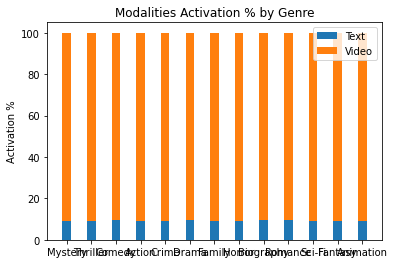

-------------------------------------------------------

Test auc_pr_micro: 0.5023 | Test auc_pr_macro: 0.4870
-------------------------------------------------------


In [49]:
# Optimizer
args.lr = 5e-5
args.patience = 5
args.max_epochs = 30
args.gradient_accumulation_steps = 4

# Scheduler
args.lr_patience = 2
args.lr_factor = 0.5

# Models parameters
args.bert_model = "bert-base-uncased"
args.hidden_sz = 768
args.vonly = True
args.lonly = True
args.aonly = True
args.orig_d_v = 4096
args.orig_d_l = 768
args.orig_d_a = 96
args.v_len = 200
args.l_len = 512
args.a_len = 200
args.attn_dropout = 0.1
args.relu_dropout = 0.1 # relu dropout
args.embed_dropout = 0.25 # embedding dropout
args.res_dropout = 0.1 # residual block dropout
args.out_dropout = 0.0 # output layer dropout
args.num_heads = 2 # number of heads for the transformer Encoder
args.layers = 1
args.attn_mask = True
args.out_gates = True

args.model = "gmu_clf_bimodal"
args.GMU = 'original'

# Train
args.visualization = False
train(args)
torch.cuda.empty_cache()

## Training multimodal (GMU original) model 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 1 | Train Loss: 0.1601
Val auc_pr_micro: 0.2789 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 2 | Train Loss: 0.1444
Val auc_pr_micro: 0.3617 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 3 | Train Loss: 0.1375
Val auc_pr_micro: 0.3043 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 4 | Train Loss: 0.1254
Val auc_pr_micro: 0.3839 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 5 | Train Loss: 0.1137
Val auc_pr_micro: 0.3773 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 6 | Train Loss: 0.1053
Val auc_pr_micro: 0.3507 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 7 | Train Loss: 0.1002
Val auc_pr_micro: 0.3471 | Val auc_pr_macro: nan
Epoch 00007: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 8 | Train Loss: 0.0934
Val auc_pr_micro: 0.4089 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 9 | Train Loss: 0.0882
Val auc_pr_micro: 0.4235 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 10 | Train Loss: 0.0833
Val auc_pr_micro: 0.3951 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 11 | Train Loss: 0.0835
Val auc_pr_micro: 0.3849 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 12 | Train Loss: 0.0793
Val auc_pr_micro: 0.4056 | Val auc_pr_macro: nan
Epoch 00012: reducing learning rate of group 0 to 1.2500e-05.


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 13 | Train Loss: 0.0743
Val auc_pr_micro: 0.4058 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 14 | Train Loss: 0.0729
Val auc_pr_micro: 0.4184 | Val auc_pr_macro: nan

No improvement. Breaking out of loop.
(100, 2304) [0.29382792 0.3267932  0.22335386 ... 0.5460096  0.34789416 0.71315426]


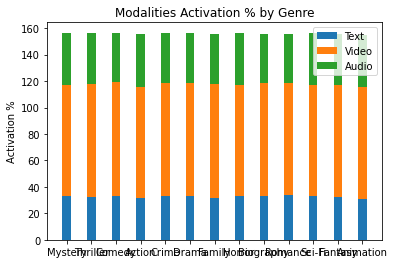

-------------------------------------------------------

Test auc_pr_micro: 0.5262 | Test auc_pr_macro: 0.4904
-------------------------------------------------------


In [54]:
# Optimizer
args.lr = 5e-5
args.patience = 5
args.max_epochs = 30
args.gradient_accumulation_steps = 8

# Scheduler
args.lr_patience = 2
args.lr_factor = 0.5

# Models parameters
args.bert_model = "bert-base-uncased"
args.hidden_sz = 768
args.vonly = True
args.lonly = True
args.aonly = True
args.orig_d_v = 4096
args.orig_d_l = 768
args.orig_d_a = 96
args.v_len = 200
args.l_len = 512
args.a_len = 200
args.attn_dropout = 0.1
args.relu_dropout = 0.1 # relu dropout
args.embed_dropout = 0.25 # embedding dropout
args.res_dropout = 0.1 # residual block dropout
args.out_dropout = 0.0 # output layer dropout
args.num_heads = 2 # number of heads for the transformer Encoder
args.layers = 1
args.attn_mask = True
args.out_gates = True

args.model = "gmu_clf_original"
args.GMU = 'original'

# Train
args.visualization = False
train(args)
torch.cuda.empty_cache()

In [ ]:
# Optimizer
args.lr = 5e-5
args.patience = 5
args.max_epochs = 30
args.gradient_accumulation_steps = 8

# Scheduler
args.lr_patience = 2
args.lr_factor = 0.5

# Models parameters
args.bert_model = "bert-base-uncased"
args.hidden_sz = 768
args.vonly = True
args.lonly = True
args.aonly = True
args.orig_d_v = 4096
args.orig_d_l = 768
args.orig_d_a = 96
args.v_len = 200
args.l_len = 512
args.a_len = 200
args.attn_dropout = 0.1
args.relu_dropout = 0.1 # relu dropout
args.embed_dropout = 0.25 # embedding dropout
args.res_dropout = 0.1 # residual block dropout
args.out_dropout = 0.0 # output layer dropout
args.num_heads = 2 # number of heads for the transformer Encoder
args.layers = 1
args.attn_mask = True
args.out_gates = False

args.model = "gmu_clf_original"
args.GMU = 'original'

# Train
args.visualization = False
train(args)
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 1 | Train Loss: 0.1597
Val auc_pr_micro: 0.3060 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 2 | Train Loss: 0.1385
Val auc_pr_micro: 0.3499 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 3 | Train Loss: 0.1255
Val auc_pr_micro: 0.3694 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 4 | Train Loss: 0.1098
Val auc_pr_micro: 0.3349 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 5 | Train Loss: 0.0934
Val auc_pr_micro: 0.3824 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 6 | Train Loss: 0.0775
Val auc_pr_micro: 0.3973 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 7 | Train Loss: 0.0651
Val auc_pr_micro: 0.3647 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 8 | Train Loss: 0.0552
Val auc_pr_micro: 0.3711 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 9 | Train Loss: 0.0436
Val auc_pr_micro: 0.3937 | Val auc_pr_macro: nan
Epoch 00009: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 10 | Train Loss: 0.0364
Val auc_pr_micro: 0.3773 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 11 | Train Loss: 0.0315
Val auc_pr_micro: 0.3977 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 12 | Train Loss: 0.0281
Val auc_pr_micro: 0.3793 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 13 | Train Loss: 0.0253
Val auc_pr_micro: 0.4073 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 14 | Train Loss: 0.0230
Val auc_pr_micro: 0.3910 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 15 | Train Loss: 0.0202
Val auc_pr_micro: 0.3945 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 16 | Train Loss: 0.0184
Val auc_pr_micro: 0.4077 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 17 | Train Loss: 0.0168
Val auc_pr_micro: 0.4010 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 18 | Train Loss: 0.0145
Val auc_pr_micro: 0.3893 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 19 | Train Loss: 0.0137
Val auc_pr_micro: 0.3970 | Val auc_pr_macro: nan
Epoch 00019: reducing learning rate of group 0 to 1.2500e-05.


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 20 | Train Loss: 0.0120
Val auc_pr_micro: 0.3949 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 21 | Train Loss: 0.0113
Val auc_pr_micro: 0.3907 | Val auc_pr_macro: nan

No improvement. Breaking out of loop.
-------------------------------------------------------

Test auc_pr_micro: 0.4641 | Test auc_pr_macro: 0.3774
-------------------------------------------------------


## Training multimodal (GMU hierarchical) model 

In [ ]:
# Optimizer
args.lr = 5e-5
args.patience = 5
args.max_epochs = 30
args.gradient_accumulation_steps = 8

# Scheduler
args.lr_patience = 2
args.lr_factor = 0.5

# Models parameters
args.bert_model = "bert-base-uncased"
args.hidden_sz = 768
args.vonly = True
args.lonly = True
args.aonly = True
args.orig_d_v = 4096
args.orig_d_l = 768
args.orig_d_a = 96
args.v_len = 200
args.l_len = 512
args.a_len = 200
args.attn_dropout = 0.1
args.relu_dropout = 0.1 # relu dropout
args.embed_dropout = 0.25 # embedding dropout
args.res_dropout = 0.1 # residual block dropout
args.out_dropout = 0.0 # output layer dropout
args.num_heads = 2 # number of heads for the transformer Encoder
args.layers = 1
args.attn_mask = True
args.out_gates = False

args.model = "gmu_clf_hierarchical"
args.GMU = 'hierarchical'

# Train
args.visualization = False
train(args)
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 1 | Train Loss: 0.1555
Val auc_pr_micro: 0.3199 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 2 | Train Loss: 0.1480
Val auc_pr_micro: 0.2438 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 3 | Train Loss: 0.1359
Val auc_pr_micro: 0.3591 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 4 | Train Loss: 0.1302
Val auc_pr_micro: 0.4009 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 5 | Train Loss: 0.1161
Val auc_pr_micro: 0.3291 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 6 | Train Loss: 0.1116
Val auc_pr_micro: 0.3075 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 7 | Train Loss: 0.1024
Val auc_pr_micro: 0.3769 | Val auc_pr_macro: nan
Epoch 00007: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 8 | Train Loss: 0.0940
Val auc_pr_micro: 0.3600 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 9 | Train Loss: 0.0867
Val auc_pr_micro: 0.3868 | Val auc_pr_macro: nan

No improvement. Breaking out of loop.
-------------------------------------------------------

Test auc_pr_micro: 0.4084 | Test auc_pr_macro: 0.4340
-------------------------------------------------------


## Training multimodal (GMU Softmax) model 

In [ ]:
# Optimizer
args.lr = 5e-5
args.patience = 5
args.max_epochs = 30
args.gradient_accumulation_steps = 8

# Scheduler
args.lr_patience = 2
args.lr_factor = 0.5

# Models parameters
args.bert_model = "bert-base-uncased"
args.hidden_sz = 768
args.vonly = True
args.lonly = True
args.aonly = True
args.orig_d_v = 4096
args.orig_d_l = 768
args.orig_d_a = 96
args.v_len = 200
args.l_len = 512
args.a_len = 200
args.attn_dropout = 0.1
args.relu_dropout = 0.1 # relu dropout
args.embed_dropout = 0.25 # embedding dropout
args.res_dropout = 0.1 # residual block dropout
args.out_dropout = 0.0 # output layer dropout
args.num_heads = 2 # number of heads for the transformer Encoder
args.layers = 1
args.attn_mask = True
args.out_gates = False

args.model = "gmu_clf_softmax"
args.GMU = 'softmax'

# Train
train(args)
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 1 | Train Loss: 0.1590
Val auc_pr_micro: 0.3229 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 2 | Train Loss: 0.1494
Val auc_pr_micro: 0.2659 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 3 | Train Loss: 0.1421
Val auc_pr_micro: 0.3621 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 4 | Train Loss: 0.1336
Val auc_pr_micro: 0.3447 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 5 | Train Loss: 0.1254
Val auc_pr_micro: 0.3751 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 6 | Train Loss: 0.1174
Val auc_pr_micro: 0.4361 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 7 | Train Loss: 0.1057
Val auc_pr_micro: 0.4182 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 8 | Train Loss: 0.1029
Val auc_pr_micro: 0.3621 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 9 | Train Loss: 0.1029
Val auc_pr_micro: 0.3918 | Val auc_pr_macro: nan
Epoch 00009: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 10 | Train Loss: 0.0965
Val auc_pr_micro: 0.4308 | Val auc_pr_macro: nan


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 11 | Train Loss: 0.0914
Val auc_pr_micro: 0.4320 | Val auc_pr_macro: nan

No improvement. Breaking out of loop.
-------------------------------------------------------

Test auc_pr_micro: 0.4709 | Test auc_pr_macro: 0.4807
-------------------------------------------------------
